In [ ]:
import torch
import torchvision

import torch.nn as nn

if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
    DEVICE = torch.device('cuda')
else:
    from torch import FloatTensor, LongTensor
    DEVICE = torch.device('cpu')

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.encoder=nn.Sequential(
        # 1 layer
        nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
        nn.LeakyReLU(0.2,inplace=True),
        # 2 layer
        nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2,inplace=True),
        # 3 layer
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,inplace=True),
        # 4 layer
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,inplace=True),
        # 5 layer
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(4,4),stride=2,padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,inplace=True),
        # 6 layer
        nn.Conv2d(in_channels=512,out_channels=4000,kernel_size=(4,4), padding = 1),
        nn.BatchNorm2d(4000),
        nn.ReLU()
    )
    self.decoder=nn.Sequential(
        # 6 layer
        nn.Conv2d(in_channels=4000,out_channels=512,kernel_size=(2,2), padding = 1),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        # 5 layer
        nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=(4,4),stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # 4 layer
        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=(4,4),stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        # 3 layer
        nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # 2 layer
        nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=(4,4),stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        # 1 layer
        nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=(4,4),stride=2,padding=1),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return x

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.t1=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=1,kernel_size=(3,3),stride=2,padding=1),
        nn.BatchNorm2d(1),
        nn.LeakyReLU(0.2,inplace=True),
        nn.Conv2d(in_channels=1,out_channels=1,kernel_size=(3,3),stride=2,padding=1),
        nn.Sigmoid()
    )

  def forward(self,x):
    return self.t1(x)

In [ ]:
from collections import namedtuple

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.utils.data import Dataset
from PIL import Image 
from PIL import ImageOps
from PIL import ImageChops

import os
import random

class MyDataset(Dataset):
  def __init__(self, img_dir, mask_dir, transform):
    self.img_dir = img_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.files = [name for name in os.listdir(img_dir) if os.path.splitext(name)[-1] == '.jpg']
    self.masks = [name for name in os.listdir(mask_dir) if os.path.splitext(name)[-1] == '.jpg']
    pass

  def __len__(self):
    return len(self.files * 2)

  def __getitem__(self, index):
    img = Image.open(os.path.join(self.img_dir, self.files[index % len(self.files)]))
    mask = Image.open(os.path.join(self.mask_dir, self.masks[index % len(self.masks)]))
    img = self.transform(img).to(DEVICE)
    img = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(img)
    mask = self.transform(mask).to(DEVICE)
    ImStruct = namedtuple("ImStruct", "image mask")
    return ImStruct(image = img, mask = mask)


In [ ]:
import math
from tqdm import tqdm
tqdm.get_lock().locks = []


def do_epoch(trainer, dataloader, name=None):
  trainer.on_epoch_begin(name, batches_count=len(dataloader))
  with tqdm(total=trainer.batches_count) as progress_bar:
    for i, batch in enumerate(dataloader):
      batch_progress = trainer.on_batch(batch)
      progress_bar.update()
      progress_bar.set_description(batch_progress)
    epoch_progress = trainer.on_epoch_end()
    progress_bar.set_description(epoch_progress)
    progress_bar.refresh()
    display(trainer.batch_out)

            
def fit(trainer, dataloader, epochs=1):
  best_val_loss = None
  for epoch in range(epochs):
    name_prefix = '[{} / {}] '.format(epoch + 1, epochs)
    do_epoch(trainer, dataloader, name=name_prefix + " Train: ")
    # Add code for validation

In [ ]:
unnormalize = transforms.Compose([
    transforms.Normalize((0,0,0), (2,2,2)),
    transforms.Normalize((-0.5,-0.5,-0.5),(1., 1., 1.)),
])

import math

class ModelTrainer():
  def __init__(self, gmodel, gcrit, gopt, dmodel, dcrit, dopt, learning_rate = 0.001, epochs = 1, alpha = 0.001):
    self.gmodel = gmodel
    self.gcrit = gcrit
    self.gopt = gopt
    self.dmodel = dmodel
    self.dcrit = dcrit
    self.dopt = dopt
    self.alpha = alpha
    self.lr = learning_rate
    self.epochs = epochs
    #self.weights_init(self.gmodel)
    #self.weights_init(self.dmodel)
    self.gmodel.train()
    self.dmodel.train()
    self.epoch_loss = 0
  # Found in the internet. People says that helps to 
  # get learning faster
  def weights_init(self, m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0) 
  
  def calculate_error(self, adv_err, rec_err):
    return self.alpha * adv_err + (1 - self.alpha) * rec_err

  def on_epoch_begin(self, name, batches_count):
    """
    Initializes metrics
    """
    self.epoch_loss = 0
    self.name = name
    self.batches_count = batches_count
        
  def on_epoch_end(self):
    """
    Outputs final metrics
    """
    return '{:>5s} Loss = {:.5f}'.format(
        self.name, self.epoch_loss / self.batches_count
    )

  def on_batch(self, batch):
    inv_mask = 1.0 - batch.mask
    # First get generated FAKE image
    # display(transforms.ToPILImage()(inv_mask[0]))
    # display(transforms.ToPILImage()(batch.mask[0]))
    fake_image = self.gmodel(batch.image * batch.mask)

    # Feed real image
    real_output = self.dmodel(batch.image)

    real_label = torch.Tensor(real_output.shape).to(DEVICE)
    real_label.requires_grad = False
    real_label.fill_(1)

    real_error = self.dcrit(real_output, real_label)

    # self.dmodel.zero_grad()
    # Feed local pictures to discriminator
    fake_output = self.dmodel(fake_image)

    fake_label = torch.Tensor(fake_output.shape).to(DEVICE)
    fake_label.requires_grad = False
    fake_label.fill_(0)

    fake_error = self.dcrit(fake_output, fake_label)

    sum_error = fake_error + real_error
    
    self.dopt.zero_grad()
    sum_error.backward(retain_graph=True)
    self.dopt.step()

    # Train generator
    # self.gmodel.zero_grad()
    gen_real_output = self.dmodel(fake_image)
    gen_real_label = torch.Tensor(gen_real_output.shape).to(DEVICE)
    gen_real_label.requires_grad = False
    gen_real_label.fill_(1)

    gen_error = self.gcrit(gen_real_output, gen_real_label)

    rec_err = (fake_image - batch.image).pow(2)
    rec_err = rec_err.mean()

    gen_error = self.calculate_error(gen_error, rec_err)

    self.gopt.zero_grad()
    gen_error.backward()
    self.gopt.step()

    self.epoch_loss += gen_error.item() + sum_error.item()
    self.batch_out = transforms.ToPILImage()(unnormalize(fake_image[0]))

In [ ]:
transform = torchvision.transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
])

dataset = MyDataset('drive/MyDrive/dataset/cats', 'drive/MyDrive/dataset/cats_mask', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=20, num_workers=0, shuffle=True)

generator = Generator().to(DEVICE)
discriminator = Discriminator().to(DEVICE)
criterion = nn.BCELoss().to(DEVICE)
goptim = torch.optim.Adam(generator.parameters())
doptim = torch.optim.Adam(discriminator.parameters())

trainer = ModelTrainer(generator, criterion, goptim, discriminator, criterion, doptim, learning_rate=0.001, alpha = 0.1)

# for i, batch in enumerate(dataloader):
#   trainer.on_batch(batch)
#   brea

#fit(trainer, dataloader, epochs = 100)    


In [ ]:
#torch.save(generator.state_dict(), "drive/MyDrive/generator5.model")

In [ ]:
generator.load_state_dict(torch.load('drive/MyDrive/generator3.model', map_location=torch.device('cpu')))

<All keys matched successfully>

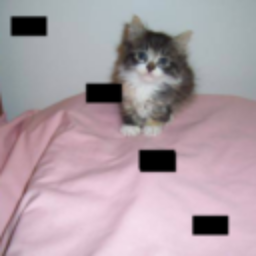

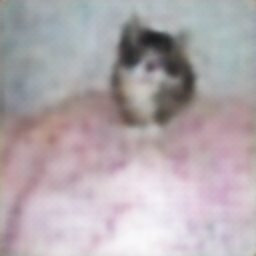

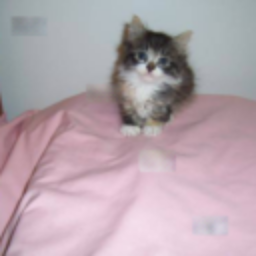

0.10554548999999902


In [ ]:
from IPython.core.profiledir import ensure_dir_exists
from torchvision.transforms.transforms import ToPILImage
from torchvision.transforms.transforms import Resize
from PIL import ImageOps
from PIL import ImageChops
import time

toimage = transforms.Compose([
    unnormalize,
    Resize(256),
    ToPILImage()
])


image = Image.open('drive/MyDrive/dataset/cats/cats_00013.jpg')
mask = Image.open('drive/MyDrive/dataset/cats_mask/cats_00012_mask.jpg')
mask = transform(mask).to(DEVICE)
image = transform(image).to(DEVICE)
save_input = ToPILImage()(Resize(256)(image * mask))
display(save_input)
image = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image)
masked = image * mask

generator.eval()
start = time.process_time()
output = generator(masked.view((-1,) + masked.shape))
end = time.process_time() - start
output = output.view(image.shape)
save_fake = toimage(output)
display(save_fake)
#display(transforms.ToPILImage()(unnormalize(output) * (1.0 - mask)))
output = unnormalize(output) * (1 - mask) + unnormalize(image) * mask
output = transforms.ToPILImage()(Resize(256)(output))
#output.save('drive/MyDrive/good3.jpg')
display(output)
print(end)

In [ ]:
save_input.save('drive/MyDrive/dataset/input7.jpg')
save_fake.save('drive/MyDrive/dataset/fake7.jpg')
output.save('drive/MyDrive/dataset/output7.jpg')